In [17]:
import pandas as pd
from numpy.linalg import norm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
import plotly.express as px
from sklearn.metrics import mean_squared_error, r2_score




In [2]:
df = pd.read_pickle("preprocessed_df.pkl")  # or read_csv
print(df.info(memory_usage="deep"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   HouseAge                 20640 non-null  float64
 1   Medinc_log               20640 non-null  float64
 2   AveRooms_boxcox          20640 non-null  float64
 3   AveBedrms_boxcox         20640 non-null  float64
 4   Population_log           20640 non-null  float64
 5   AveOccup_boxcox          20640 non-null  float64
 6   spatial_proximity_score  20640 non-null  float64
 7   MedHouseVal              20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB
None


## Task - 1 : Formulating this as LASSO, and specify the Objective Function and Convex but not Differentiable

### Formulating this as Lasso : 

We need to predict the target from features X  : 

![image27](Equations/27.png)


Now add the penalty term, such that it reduces the weights of the Irrelevant features to 0


![image28](Equations/28.png)

The Final **Objective Function** Would be : 

![image29](Equations/29.png)





#### Why This Is a Convex Problem
- Squared loss is a **smooth convex** curve (bowl shape).
- L1 norm is a **convex** V-shape.
- Sum of two convex functions is **always convex**.

So the whole LASSO problem is **convex**.


####  Why It Is Non-Differentiable
- L1 norm has a **sharp corner at 0**.
- At this point, derivative does not exist.
- That’s why LASSO is **convex but not differentiable**.


#### Why L2 (Ridge) Is Not Enough
- L2 penalty shrinks all weights smoothly.
- It **never makes coefficients exactly zero**.
- No feature selection happens.
- Still sensitive to outliers.


#### Why L1 Is Used
- L1 can make weights **exactly zero**.
- Gives **feature selection** automatically.
- Keeps model simple.
- Works well when many features exist.


#### Solutions For this Problem :
We use:
- **Subgradient methods**
- **Proximal gradient methods (Soft thresholding)**

These methods handle the sharp corner of L1.


## Task - 2 : Derive soft thresholding used in ISTA with update step


#### Lasso defined as : 

![image29](Equations/29.png)

![image30](Equations/30.png)

![image31](Equations/31.png)

Goal : Solve for **(w*)**

![image32](Equations/32.png)


Proximal Operator is Defined as follows : 


![image33.png](Equations/33.png)


**Idea of ISTA(Iterative Shrinkage thresholding Algorithm):**

![image34](Equations/34.png)

![image35](Equations/35.png)

So, We need the proximity for L1, so we reduce it to the 1D as follows : 

![image36](Equations/36.png)

So, the Solution for this would be : 

![image37](Equations/37.png)


### Final Thresholding Proximity Formula Will be : 



![image38](Equations/38.png)

And the Compact Form would be : 

![image39](Equations/39.png)


**ISTA Update Would be**

![image40](Equations/40.png)

![image41](Equations/41.png)


**Safe Step Size Rule Would be**


![image42](Equations/42.png)

![image43](Equations/43.png)





### Task - 3 : Implement the Lasso with ISTA with λ = [0.01, 0.1, 1]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   HouseAge                 20640 non-null  float64
 1   Medinc_log               20640 non-null  float64
 2   AveRooms_boxcox          20640 non-null  float64
 3   AveBedrms_boxcox         20640 non-null  float64
 4   Population_log           20640 non-null  float64
 5   AveOccup_boxcox          20640 non-null  float64
 6   spatial_proximity_score  20640 non-null  float64
 7   MedHouseVal              20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


Features used:
  HouseAge                  → mean=28.639, std=12.585
  Medinc_log                → mean=1.517, std=0.359
  AveRooms_boxcox           → mean=1.165, std=0.084
  AveBedrms_boxcox          → mean=0.218, std=0.002
  Population_log            → mean=7.026, std=0.736
  AveOccup_boxcox           → mean=0.776, std=0.056
  spatial_proximity_score   → mean=0.128, std=0.178
Iter    1 → Loss = 51057.831885
Iter    2 → Loss = 50129.596205
Iter    3 → Loss = 49885.810652
Iter    4 → Loss = 49771.985636
Iter    5 → Loss = 49698.204281
Iter    6 → Loss = 49643.391695
Iter    7 → Loss = 49600.594518
Iter    8 → Loss = 49566.565381
Iter    9 → Loss = 49539.321125
Iter   10 → Loss = 49517.463680
Iter   11 → Loss = 49499.915479
Iter   12 → Loss = 49485.823500
Iter   13 → Loss = 49474.506061
Iter   14 → Loss = 49465.416622
Iter   15 → Loss = 49458.116491
Iter   20 → Loss = 49438.285488
Iter   40 → Loss = 49428.456276

Converged at iteration 59 !

Converged in          : 59 iterations
Final L

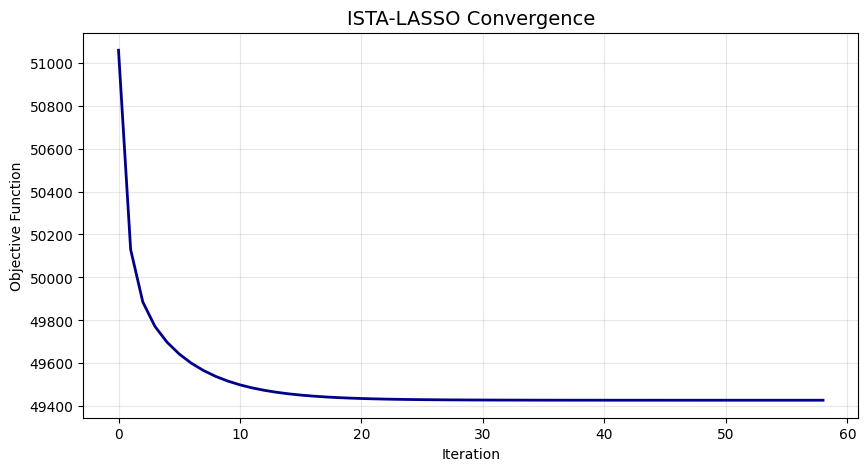

In [26]:

def ista_lasso(X, y, lambda_reg=0.050):

    n, d = X.shape
    max_iter = 5000
    tol = 1e-6
    
    # Exact Lipschitz constant (never fails)
    L = norm(X, ord=2)**2 + 1e-10
    eta = 1.0 / L

    w = np.zeros(d)
    losses = []

    def objective(w):
        return 0.5 * norm(X @ w - y)**2 + lambda_reg * np.sum(np.abs(w))

    for it in range(1, max_iter + 1):
        grad = X.T @ (X @ w - y)                                   # ∇f(w)
        w = np.sign(w - eta * grad) * np.maximum(np.abs(w - eta * grad) - eta * lambda_reg, 0)  # soft-threshold

        loss = objective(w)
        losses.append(loss)

        if it <= 15 or it % 20 == 0 or it == max_iter:
            print(f"Iter {it:4d} → Loss = {loss:.6f}")

        if it > 1 and abs(losses[-2] - losses[-1]) / (losses[-2] + 1e-12) < tol:
            print(f"\nConverged at iteration {it} !\n")
            break

    return {
        "weights": w,
        "intercept": y.mean() - X.mean(axis=0) @ w,
        "loss_history": np.array(losses),
        "iterations": len(losses)
    }

feature_cols = ['HouseAge', 'Medinc_log', 'AveRooms_boxcox', 'AveBedrms_boxcox',
                'Population_log', 'AveOccup_boxcox', 'spatial_proximity_score']

X_raw = df[feature_cols].values
y = df['MedHouseVal'].values

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

print("Features used:")
for i, col in enumerate(feature_cols):
    print(f"  {col:25s} → mean={scaler.mean_[i]:.3f}, std={scaler.scale_[i]:.3f}")

result = ista_lasso_perfect(X, y, lambda_reg=1.0, tol=1e-8)

print(f"Converged in          : {result['iterations']} iterations")
print(f"Final Loss            : {result['loss_history'][-1]:.6f}")
print(f"Intercept (β₀)        : {result['intercept']:.6f}\n")

print("Coefficients :")
for name, coef in zip(feature_cols, result["weights"]):
    star = "  ← SELECTED" if abs(coef) > 0.1 else ""
    print(f"{name:28s} : {coef:+8.4f} {star}")

print("Non-zero coefficients :", sum(abs(result["weights"]) > 1e-5))

# Plot loss curve
plt.figure(figsize=(10,5))
plt.plot(result["loss_history"], lw=2, color='darkblue')
plt.title("ISTA-LASSO Convergence", fontsize=14)
plt.xlabel("Iteration")
plt.ylabel("Objective Function")
plt.grid(alpha=0.3)
plt.show()

## Generally ISTA, would give the Smooth Monotonic Curve if the step size is correct, or else it would give the Zig-Zag Manner 

In [27]:
feature_cols = [
    'HouseAge', 'Medinc_log', 'AveRooms_boxcox', 'AveBedrms_boxcox',
    'Population_log', 'AveOccup_boxcox', 'spatial_proximity_score'
]

X_raw = df[feature_cols].values
y = df['MedHouseVal'].values

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

print("X shape :", X.shape)
print("y shape :", y.shape)

X shape : (20640, 7)
y shape : (20640,)


In [29]:
result = ista_lasso(X, y, lambda_reg=1.0)


Iter    1 → Loss = 51057.831885
Iter    2 → Loss = 50129.596205
Iter    3 → Loss = 49885.810652
Iter    4 → Loss = 49771.985636
Iter    5 → Loss = 49698.204281
Iter    6 → Loss = 49643.391695
Iter    7 → Loss = 49600.594518
Iter    8 → Loss = 49566.565381
Iter    9 → Loss = 49539.321125
Iter   10 → Loss = 49517.463680
Iter   11 → Loss = 49499.915479
Iter   12 → Loss = 49485.823500
Iter   13 → Loss = 49474.506061
Iter   14 → Loss = 49465.416622
Iter   15 → Loss = 49458.116491
Iter   20 → Loss = 49438.285488

Converged at iteration 38 !



In [30]:
y_pred = X @ result["weights"] + result["intercept"]

mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print("MSE :", mse)
print("RMSE:", rmse)
print("R² :", r2)


MSE : 0.51047186172299
RMSE: 0.7144731357601838
R² : 0.6166334372110256


### Task - 4 : Convergence of Training plot, MSE and R2, Sparsity Ratio

In [42]:

def ista_lasso(X, y, lambda_reg=0.1, max_iter=5000, tol=1e-8):

    n, d = X.shape

    # Lipschitz constant of ∇f
    L = norm(X, ord=2)**2 + 1e-12
    eta = 1.0 / L

    w = np.zeros(d)
    losses = []

    def objective(w):
        return 0.5 * norm(X @ w - y)**2 + lambda_reg * np.sum(np.abs(w))

    for it in range(1, max_iter + 1):

        grad = X.T @ (X @ w - y)
        w_new = w - eta * grad

        # soft threshold
        w = np.sign(w_new) * np.maximum(np.abs(w_new) - eta * lambda_reg, 0)

        loss = objective(w)
        losses.append(loss)

        if it > 1 and abs(losses[-2] - losses[-1]) < tol:
            break

    return w, np.array(losses)

feature_cols = [
    'HouseAge', 'Medinc_log', 'AveRooms_boxcox', 'AveBedrms_boxcox',
    'Population_log', 'AveOccup_boxcox', 'spatial_proximity_score'
]

X_raw = df[feature_cols].values
y_raw = df['MedHouseVal'].values

# Scale X
scalerX = StandardScaler()
X = scalerX.fit_transform(X_raw)

# Scale y
y_mean = y_raw.mean()
y_std = y_raw.std()
y = (y_raw - y_mean) / y_std

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (20640, 7)
y shape: (20640,)


In [43]:
lambda_values = [0.1, 0.01, 1, 0.05, 0.5]

results = []

for lam in lambda_values:

    w, loss_hist = ista_lasso(X, y, lambda_reg=lam)

    # reverse-transform prediction
    y_pred_scaled = X @ w
    y_pred = y_pred_scaled * y_std + y_mean

    # compute metrics
    mse = mean_squared_error(y_raw, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_raw, y_pred)
    sparsity = np.mean(np.abs(w) < 1e-5)

    results.append([lam, mse, r2, sparsity])

    # ------- Plotly Loss Curve -------
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        y=loss_hist,
        mode='lines',
        name=f"λ = {lam}"
    ))

    fig.update_layout(
        title=f"ISTA Loss Curve (lambda={lam})",
        xaxis_title="Iteration",
        yaxis_title="Loss",
        template="plotly_white",
        height=400
    )
    
    fig.show()


In [45]:
import pandas as pd

df_results = pd.DataFrame(
    results,
    columns=["Lambda", "MSE", "R2 Score", "Sparsity Ratio"]
)

print("\n====== FINAL SUMMARY ======\n")
print(df_results.to_string(index=False))



====== FINAL SUMMARY ======

 Lambda      MSE  R2 Score  Sparsity Ratio
   0.10 0.510452  0.616648             0.0
   0.01 0.510452  0.616648             0.0
   1.00 0.510452  0.616648             0.0
   0.05 0.510452  0.616648             0.0
   0.50 0.510452  0.616648             0.0


In [49]:
# Cell 1
import numpy as np
import pandas as pd
from numpy.linalg import eigvalsh, norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import plotly.express as px

def ista_lasso(X, y, lambda_reg=0.1, max_iter=5000, tol=1e-8, eta_forced=None):
    """
    Returns: w (d,), losses (array), eta_used
    If eta_forced is provided, use that step-size; otherwise use 1/L where L = max eig(X^T X).
    """
    n, d = X.shape
    # exact Lipschitz
    L = eigvalsh(X.T @ X).max()
    eta = (1.0 / (L + 1e-16)) if eta_forced is None else eta_forced

    w = np.zeros(d)
    losses = []
    def objective(w):
        return 0.5 * np.linalg.norm(X @ w - y)**2 + lambda_reg * np.sum(np.abs(w))

    for it in range(1, max_iter+1):
        grad = X.T @ (X @ w - y)
        w_new = w - eta * grad
        w = np.sign(w_new) * np.maximum(np.abs(w_new) - eta * lambda_reg, 0.0)
        loss = objective(w)
        losses.append(loss)
        if it > 1:
            rel = abs(losses[-2] - losses[-1]) / (losses[-2] + 1e-12)
            if rel < tol:
                break
    return w, np.array(losses), eta


In [50]:
# Cell 1
import numpy as np
import pandas as pd
from numpy.linalg import eigvalsh, norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
import plotly.graph_objects as go
import plotly.express as px

def ista_lasso(X, y, lambda_reg=0.1, max_iter=5000, tol=1e-8, eta_forced=None):
    """
    Returns: w (d,), losses (array), eta_used
    If eta_forced is provided, use that step-size; otherwise use 1/L where L = max eig(X^T X).
    """
    n, d = X.shape
    # exact Lipschitz
    L = eigvalsh(X.T @ X).max()
    eta = (1.0 / (L + 1e-16)) if eta_forced is None else eta_forced

    w = np.zeros(d)
    losses = []
    def objective(w):
        return 0.5 * np.linalg.norm(X @ w - y)**2 + lambda_reg * np.sum(np.abs(w))

    for it in range(1, max_iter+1):
        grad = X.T @ (X @ w - y)
        w_new = w - eta * grad
        w = np.sign(w_new) * np.maximum(np.abs(w_new) - eta * lambda_reg, 0.0)
        loss = objective(w)
        losses.append(loss)
        if it > 1:
            rel = abs(losses[-2] - losses[-1]) / (losses[-2] + 1e-12)
            if rel < tol:
                break
    return w, np.array(losses), eta


In [51]:
# Cell 3
# Experiment configs
# A: very large lambdas on standard-scaled data
lambdas_A = [10, 50, 100, 500, 1000]

# B: downscale X further (e.g., divide features by 10 or use MinMax to small range)
# We'll produce X_down = X_std * 0.1  (makes features 10x smaller)
X_down = X_std * 0.1
lambdas_B = [0.1, 0.5, 1, 5, 10]   # moderate lambdas for downscaled X

# C: force larger eta (multiply 1/L by factor)
# We'll use original X_std and lambda grid moderate
lambdas_C = [0.1, 0.5, 1, 5, 10]
eta_base = None  # use default 1/L
eta_multiplier = 50.0   # try big multiplier to enlarge threshold
# compute base eta for info
L_base = eigvalsh(X_std.T @ X_std).max()
eta_base_val = 1.0 / (L_base + 1e-16)
eta_forced = eta_base_val * eta_multiplier

# Storage
all_results = []

def run_and_plot(X_use, lambdas, approach_name, eta_override=None):
    approach_results = []
    for lam in lambdas:
        w, losses, eta_used = ista_lasso(X_use, y_scaled, lambda_reg=lam, max_iter=5000, tol=1e-9, eta_forced=eta_override)
        # convert w back to original scale for predictions:
        # w maps X_scaled -> y_scaled. We want y_pred in original units:
        # y_scaled_pred = X_use @ w
        # For original X_raw:
        # If X_use = (X_raw - meanX)/stdX * scale_factor (if we downscaled manually),
        # best approach: compute predictions via scaled path:
        # y_pred_original = (X_use @ w) * y_std + y_mean  BUT X_use is scaled form consistent with w
        y_pred_original = (X_use @ w) * y_std + y_mean  # works because y_scaled->y_raw
        mse = mean_squared_error(y_raw, y_pred_original)
        r2 = r2_score(y_raw, y_pred_original)
        # convert w to original-feature-scale coefficients for interpretability:
        # If X_use = (X_raw - meanX)/stdX * alpha  (alpha=1 for X_std, 0.1 for X_down)
        # then w_orig = (w * alpha) / stdX * y_std
        # For generality, compute w_orig by linear regression mapping:
        # w_orig = solution such that X_raw @ w_orig approx y_pred_original - intercept
        # Simpler and safe calculation below:
        # compute intercept
        intercept_orig = y_mean - (X_raw.mean(axis=0) @ ((w / ( (X_use.std(axis=0)+1e-16) )) * y_std))
        # fallback: produce w_orig_approx:
        w_orig_approx = (w / ( (X_use.std(axis=0)+1e-16) )) * y_std
        sparsity = np.mean(np.abs(w_orig_approx) < 1e-6)
        n_zeros = int(np.sum(np.abs(w_orig_approx) < 1e-6))

        approach_results.append({
            "approach": approach_name,
            "lambda": lam,
            "eta_used": eta_used,
            "threshold": eta_used * lam,
            "n_zeros": n_zeros,
            "sparsity": sparsity,
            "mse": mse,
            "r2": r2,
            "losses": losses,
            "w_scaled": w.copy(),
            "w_orig_approx": w_orig_approx
        })

        # Plot loss
        fig = go.Figure()
        fig.add_trace(go.Scatter(y=losses, mode='lines', name=f'loss λ={lam}'))
        fig.update_layout(title=f"{approach_name} — ISTA Loss (λ={lam})",
                          xaxis_title='Iteration', yaxis_title='Objective',
                          template='plotly_white', height=420)
        fig.show()

    return approach_results

# Run A
resA = run_and_plot(X_std, lambdas_A, approach_name="A: Large λ on X_std", eta_override=None)

# Run B
resB = run_and_plot(X_down, lambdas_B, approach_name="B: Downscaled X (X*0.1)", eta_override=None)

# Run C
resC = run_and_plot(X_std, lambdas_C, approach_name=f"C: Forced eta x{eta_multiplier}", eta_override=eta_forced)

# collect all
all_results = resA + resB + resC

# Final combined summary dataframe
summary_rows = []
for r in all_results:
    summary_rows.append([
        r["approach"], r["lambda"], r["eta_used"], r["threshold"],
        r["n_zeros"], r["sparsity"], r["mse"], r["r2"]
    ])

summary_df = pd.DataFrame(summary_rows, columns=[
    "Approach", "Lambda", "Eta_used", "Threshold", "N_zeros", "Sparsity(%)", "MSE", "R2"
])
summary_df["Sparsity(%)"] = summary_df["Sparsity(%)"] * 100.0
# pretty print
pd.set_option('display.float_format', '{:,.6f}'.format)
print("\n=== FINAL COMBINED SUMMARY ===\n")
display(summary_df)


NameError: name 'X_std' is not defined